# Задание 1 (3 балла)

Обучите word2vec модели с негативным семплированием (cbow и skip-gram) с помощью tensorflow аналогично тому, как это было сделано в семинаре. Вам нужно изменить следующие пункты: 
1) добавьте лемматизацию в предобработку (любым способом)  
2) измените размер окна на 6 для cbow и 12 для skip gram (обратите внимание, что размер окна = #слов слева + #слов справа, в gen_batches в семинаре window не так используется)  
3) измените часть с np.random.randint(vocab_size) так, чтобы случайные негативные примеры выбирались обратно пропорционально частотностям слов (частотные должны выбираться реже, а редкие чаще)

Выберете несколько не похожих по смыслу слов, и протестируйте полученные эмбединги (найдите ближайшие слова и оцените правильность, как в семинаре)

In [4]:
import tensorflow as tf
import re
import numpy as np
import pandas as pd
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_distances
from razdel import tokenize
import pymorphy2

from IPython.display import Image
from IPython.core.display import HTML 
%matplotlib inline

/home/nanosemantics/.local/lib/python3.8/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/home/nanosemantics/.local/lib/python3.8/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  me

In [5]:
morph = pymorphy2.MorphAnalyzer()
data = open('wiki_data.txt', encoding='utf-8').read().splitlines()

Добавим в препроцессинг лемматизацию:

In [6]:
def preprocess(text):
    text = re.sub(r'[_—–-]+', ' ', text)
    normalized_text = [word.text.strip(punctuation) for word in tokenize(text)]
    normalized_text = [word.lower() for word in normalized_text if word and word not in punctuation]
    normalized_text = [morph.parse(word)[0].normal_form for word in normalized_text]
    return normalized_text

Составим словарь и отфильтруем значения по частотности:

In [7]:
vocab = Counter()

for text in data:
    vocab.update(preprocess(text))

In [8]:
filtered_vocab = {word: freq for word, freq in dict(vocab).items() if freq > 30}

In [9]:
word2id = {'PAD': 0}

for word in filtered_vocab.keys():
    word2id[word] = len(word2id)

In [10]:
id2word = {i:word for word, i in word2id.items()}

Это понадобится для изменения сэмплинга

In [11]:
def inv_p(vocab, word):
    return sum(vocab.values())/vocab[word]

In [12]:
id2prob = {id_: inv_p(filtered_vocab, word) if word != 'PAD' else 0 for id_, word in id2word.items()}

In [13]:
probs = np.array(list(id2prob.values()))

In [14]:
probs

array([     0.        ,  15939.42808219,    472.1835244 , ...,
        80246.77586207, 108239.8372093 , 136891.55882353])

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from torch import softmax
import torch
%matplotlib inline

In [16]:
inverse_probs = softmax(torch.tensor((probs - np.min(probs)) / (np.max(probs) - np.min(probs))), dim=0)

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

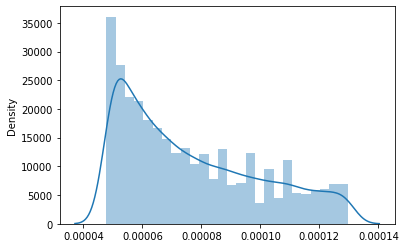

In [17]:
sns.distplot(inverse_probs)

Тексты переведем в набор id

In [18]:
sentences = []

for text in data:
    tokens = preprocess(text)
    ids = [word2id[token] for token in tokens if token in word2id]
    sentences.append(ids)

In [197]:
embeddings_1 = model.layers[0].get_weights()[0]
embeddings_2 = model.layers[2].get_weights()[0].T
embeddings = np.mean([embeddings_1, embeddings_2], axis=0)

In [198]:
embeddings = np.mean([embeddings_1, embeddings_2], axis=0)

In [199]:
most_similar('россия', embeddings)

['россия',
 'учение',
 'наследовать',
 'принять',
 '75',
 'шайба',
 'дикобраз',
 'семьдесят',
 'ель',
 'крышка']

Заменили в функции gen_batches способ выбора негативных примеров на вероятности inverse_probs, и window

In [19]:
vocab_size = probs.shape[0]

In [20]:
# skip gram
def modified_gen_batches_sg(sentences, window = 5, batch_size=1000):
    while True:
        X_target = []
        X_context = []
        y = []
        
        indent = window // 2
        
        for sent in sentences:
            for i in range(indent, len(sent)-1):
                word = sent[i]
                context = sent[i-indent:i] + sent[i+1:i+indent]
                for context_word in context:
                    X_target.append(word)
                    X_context.append(context_word)
                    y.append(1)
                    
                    X_target.append(word)
                    X_context.append(np.random.choice(range(vocab_size), p=inverse_probs))
                    y.append(0)
                    
                    if len(X_target) >= batch_size:
                        X_target = np.array(X_target)
                        X_context = np.array(X_context)
                        y = np.array(y)
                        yield ((X_target, X_context), y)
                        X_target = []
                        X_context = []
                        y = []
                        
# оригинальная функция skip gram
def gen_batches_sg(sentences, window = 5, batch_size=1000):
    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-window):i] + sent[i+1:i+window]
                for context_word in context:
                    X_target.append(word)
                    X_context.append(context_word)
                    y.append(1)
                    
                    X_target.append(word)
                    X_context.append(np.random.randint(vocab_size))
                    y.append(0)
                    
                    if len(X_target) >= batch_size:
                        X_target = np.array(X_target)
                        X_context = np.array(X_context)
                        y = np.array(y)
                        yield ((X_target, X_context), y)
                        X_target = []
                        X_context = []
                        y = []


In [84]:
def modified_gen_batches_cbow(sentences, window = 5, batch_size=1000):
    while True:
        X_target = []
        X_context = []
        y = []
        indent = window // 2
        
        for sent in sentences:
            for i in range(indent, len(sent)-1):
                word = sent[i]
                context = sent[i-indent:i] + sent[i+1:i+indent]

                X_target.append(word)
                X_context.append(context)
                y.append(1)
                
                X_target.append(np.random.choice(vocab_size, p=inverse_probs))
                X_context.append(context)
                y.append(0)

                if len(X_target) == batch_size:
                    X_target = np.array(X_target)
                    X_context = tf.keras.preprocessing.sequence.pad_sequences(X_context, maxlen=window*2)
                    y = np.array(y)
                    yield ((X_target, X_context), y)
                    X_target = []
                    X_context = []
                    y = []
                    
def gen_batches_cbow(sentences, window = 5, batch_size=1000):
    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-window):i] + sent[i+1:i+window]

                X_target.append(word)
                X_context.append(context)
                y.append(1)
                
                X_target.append(np.random.randint(vocab_size))
                X_context.append(context)
                y.append(0)

                if len(X_target) == batch_size:
                    X_target = np.array(X_target)
                    X_context = tf.keras.preprocessing.sequence.pad_sequences(X_context, maxlen=window*2)
                    y = np.array(y)
                    yield ((X_target, X_context), y)
                    X_target = []
                    X_context = []
                    y = []

In [85]:
inputs_target = tf.keras.layers.Input(shape=(1,))
inputs_context = tf.keras.layers.Input(shape=(1,))

embeddings_target = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_target, )
embeddings_context = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_context, )

target = tf.keras.layers.Flatten()(embeddings_target)
context = tf.keras.layers.Flatten()(embeddings_context)

dot = tf.keras.layers.Dot(1)([target, context])
outputs = tf.keras.layers.Activation(activation='sigmoid')(dot)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [86]:
model_sg_orig = tf.keras.Model(inputs=[inputs_target, inputs_context], 
                       outputs=outputs)

model_sg_orig.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_sg_orig.fit(gen_batches_sg(sentences[:19000], window=12),
          validation_data=gen_batches_sg(sentences[19000:], window=12),
          batch_size=1000,
          steps_per_epoch=1000,
          validation_steps=50,
         epochs=2)

Epoch 1/2
1000/1000 [==============================] - 4s 3ms/step - loss: 0.5628 - accuracy: 0.7155 - val_loss: 0.5827 - val_accuracy: 0.6864
Epoch 2/2
1000/1000 [==============================] - 3s 3ms/step - loss: 0.4595 - accuracy: 0.7820 - val_loss: 0.5672 - val_accuracy: 0.7089


In [87]:
model_sg_mod = tf.keras.Model(inputs=[inputs_target, inputs_context], 
                       outputs=outputs)

model_sg_mod.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_sg_mod.fit(modified_gen_batches_sg(sentences[:19000], window=12),
          validation_data=modified_gen_batches_sg(sentences[19000:], window=12),
          batch_size=1000,
          steps_per_epoch=1000,
          validation_steps=50,
         epochs=2)

Epoch 1/2
1000/1000 [==============================] - 539s 539ms/step - loss: 0.3239 - accuracy: 0.8513 - val_loss: 0.5532 - val_accuracy: 0.7383
Epoch 2/2
1000/1000 [==============================] - 538s 538ms/step - loss: 0.4379 - accuracy: 0.8047 - val_loss: 0.4424 - val_accuracy: 0.8036


In [28]:
#cbow negative sampling
inputs_target = tf.keras.layers.Input(shape=(1,))
inputs_context = tf.keras.layers.Input(shape=(10,))

embeddings_target = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_target, )
embeddings_context = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_context, )

target = tf.keras.layers.Flatten()(embeddings_target)
context = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1))(embeddings_context)
dot = tf.keras.layers.Dot(1)([target, context])

outputs = tf.keras.layers.Activation(activation='sigmoid')(dot)


optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [35]:
model_cbow_orig = tf.keras.Model(inputs=[inputs_target, inputs_context], 
                       outputs=outputs)

model_cbow_orig.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_cbow_orig.fit(gen_batches_cbow(sentences[:19000], window=6),
          validation_data=gen_batches_cbow(sentences[19000:],  window=6),
          batch_size=1000,
          steps_per_epoch=1000,
          validation_steps=100,
         epochs=4)

Epoch 1/4
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1579 - accuracy: 0.9411 - val_loss: 0.3211 - val_accuracy: 0.8817
Epoch 2/4
1000/1000 [==============================] - 6s 6ms/step - loss: 0.1506 - accuracy: 0.9442 - val_loss: 0.3449 - val_accuracy: 0.8756
Epoch 3/4
1000/1000 [==============================] - 6s 6ms/step - loss: 0.2102 - accuracy: 0.9159 - val_loss: 0.3262 - val_accuracy: 0.8788
Epoch 4/4
1000/1000 [==============================] - 6s 6ms/step - loss: 0.2049 - accuracy: 0.9179 - val_loss: 0.2862 - val_accuracy: 0.8941


In [36]:
model_cbow_mod = tf.keras.Model(inputs=[inputs_target, inputs_context], 
                       outputs=outputs)

model_cbow_mod.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_cbow_mod.fit(modified_gen_batches_cbow(sentences[:19000], window=6),
          validation_data=gen_batches_cbow(sentences[19000:],  window=6),
          batch_size=1000,
          steps_per_epoch=1000,
          validation_steps=100,
         epochs=4)

Epoch 1/4
1000/1000 [==============================] - 75s 75ms/step - loss: 0.1388 - accuracy: 0.9509 - val_loss: 0.2963 - val_accuracy: 0.8921
Epoch 2/4
1000/1000 [==============================] - 75s 75ms/step - loss: 0.1345 - accuracy: 0.9523 - val_loss: 0.3198 - val_accuracy: 0.8853
Epoch 3/4
1000/1000 [==============================] - 75s 75ms/step - loss: 0.1652 - accuracy: 0.9352 - val_loss: 0.3601 - val_accuracy: 0.8824
Epoch 4/4
1000/1000 [==============================] - 75s 75ms/step - loss: 0.1637 - accuracy: 0.9356 - val_loss: 0.3323 - val_accuracy: 0.8957


Качество на модифицированных вариантах по метрикам немного лучше.

In [69]:
def get_embeddings(model):
    embeddings_1 = model.layers[2].get_weights()[0]
    embeddings_2 = model.layers[3].get_weights()[0]
    embeddings = np.mean([embeddings_1, embeddings_2], axis=0)
    return embeddings

In [44]:
def most_similar(word, embeddings):
    similar = [id2word[i] for i in 
               cosine_distances(embeddings[word2id[word]].reshape(1, -1), embeddings).argsort()[0][:10]]
    return similar

In [143]:
most_similar('пигмент', model_sg_orig.layers[2].get_weights()[0])

['пигмент',
 'автобиографический',
 'стул',
 'партнёрство',
 'костромской',
 'конюшня',
 'байкал',
 'джеральд',
 'аида',
 'пониматься']

In [144]:
most_similar('пигмент', model_sg_mod.layers[2].get_weights()[0])

['пигмент',
 'автобиографический',
 'стул',
 'партнёрство',
 'костромской',
 'конюшня',
 'байкал',
 'джеральд',
 'аида',
 'пониматься']

Тоже самое.

In [134]:
model_cbow_orig.layers

In [145]:
most_similar('пигмент', model_cbow_orig.layers[2].get_weights()[0])

['пигмент',
 'мажорный',
 'самоповреждение',
 'заветинский',
 'филамент',
 'fretilin',
 'григорашвили',
 'гау',
 'прожа',
 'уэмбль']

In [146]:
most_similar('пигмент', model_cbow_mod.layers[2].get_weights()[0])

['пигмент',
 'мажорный',
 'самоповреждение',
 'заветинский',
 'филамент',
 'fretilin',
 'григорашвили',
 'гау',
 'прожа',
 'уэмбль']

Модели обученные на разного размера окнах ничем не отличаются друг от друга в качестве представления близлежащих слов

# Задание 2 (3 балла)

Обучите 1 word2vec и 1 fastext модель в gensim. В каждой из модели нужно задать все параметры, которые мы разбирали на семинаре. Заданные значения должны отличаться от дефолтных и от тех, что мы использовали на семинаре.

In [61]:
import gensim

In [62]:
data = open('wiki_data.txt').read().split('\n')

In [64]:
data = data[:10000]

In [66]:
texts = [preprocess(text) for text in data]

In [79]:
%%time
w2v_1 = gensim.models.Word2Vec(texts, 
                             vector_size=200, 
                             min_count=10, 
                             max_vocab_size=5000,
                             window=5,
                             epochs=7)

CPU times: user 20.9 s, sys: 177 ms, total: 21.1 s
Wall time: 7.68 s


In [81]:
w2v_1.wv.most_similar('кпсс')

[('цк', 0.9043331146240234),
 ('секретарь', 0.8034602403640747),
 ('сср', 0.77491694688797),
 ('заместитель', 0.7304462790489197),
 ('б', 0.7300452589988708),
 ('председатель', 0.6950972676277161),
 ('партийный', 0.6592340469360352),
 ('1934', 0.6590571403503418),
 ('рсфср', 0.6563038229942322),
 ('1957', 0.6504722237586975)]

In [85]:
w2v_1.wv.most_similar('убийство')

[('убийца', 0.6532257199287415),
 ('полиция', 0.5652472376823425),
 ('смерть', 0.5590037703514099),
 ('арестовать', 0.5450291633605957),
 ('муж', 0.5373110175132751),
 ('тюрьма', 0.5313440561294556),
 ('возвращение', 0.5253629088401794),
 ('убитый', 0.5155385732650757),
 ('жена', 0.49530333280563354),
 ('суд', 0.4902786910533905)]

In [87]:
%%time
w2v_2 = gensim.models.Word2Vec(texts, 
                             vector_size=100, 
                             max_vocab_size=30000,
                             window=12,
                             sample=1e-5,
                             epochs=10)

CPU times: user 19.5 s, sys: 138 ms, total: 19.7 s
Wall time: 7.94 s


In [88]:
w2v_2.wv.most_similar('кпсс')

[('цк', 0.9943201541900635),
 ('обком', 0.9927290081977844),
 ('сср', 0.9906488060951233),
 ('киргизский', 0.9873512387275696),
 ('райком', 0.9866804480552673),
 ('горком', 0.9841035604476929),
 ('созыв', 0.9784717559814453),
 ('1925', 0.9784041047096252),
 ('1936', 0.977519690990448),
 ('секретарь', 0.9769953489303589)]

In [89]:
w2v_2.wv.most_similar('убийство')

[('убедить', 0.9803911447525024),
 ('преступник', 0.9762445092201233),
 ('попросить', 0.9752590656280518),
 ('полицейский', 0.9732139706611633),
 ('заявлять', 0.9686585068702698),
 ('петио', 0.9678609371185303),
 ('событие', 0.967854917049408),
 ('моррис', 0.9661118984222412),
 ('согласиться', 0.9654927253723145),
 ('вспоминать', 0.9635506272315979)]

In [90]:
%%time

ft_1 = gensim.models.FastText(texts)

CPU times: user 1min 36s, sys: 801 ms, total: 1min 37s
Wall time: 36 s


In [91]:
ft_1.wv.most_similar('кпсс')

[('монастырь', 0.9114718437194824),
 ('собор', 0.8867537975311279),
 ('храм', 0.8835501670837402),
 ('святилище', 0.8676038980484009),
 ('святск', 0.865126371383667),
 ('святыня', 0.8515477180480957),
 ('часовня', 0.8238818645477295),
 ('богородица', 0.8059545159339905),
 ('святосла', 0.8032811284065247),
 ('монах', 0.8030121922492981)]

In [106]:
ft_1.wv.most_similar('убийство')

[('самоубийство', 0.9728110432624817),
 ('масонство', 0.8620576858520508),
 ('любопытство', 0.8598005771636963),
 ('детство', 0.8476846814155579),
 ('бегство', 0.8476760387420654),
 ('чувство', 0.8414034247398376),
 ('свойство', 0.8411504626274109),
 ('убранство', 0.8383883833885193),
 ('совершенство', 0.8383099436759949),
 ('ходатайство', 0.8348193764686584)]

In [107]:
%%time

ft_2 = gensim.models.FastText(texts, min_n=1, max_n=9)

CPU times: user 4min 2s, sys: 1.7 s, total: 4min 4s
Wall time: 1min 26s


In [109]:
ft_2.wv.most_similar('кпсс')

[('эссекс', 0.7894317507743835),
 ('комиссар', 0.7708514332771301),
 ('класс', 0.7536948323249817),
 ('бсср', 0.749340832233429),
 ('ссср', 0.7482654452323914),
 ('сс', 0.7476797699928284),
 ('асс', 0.7465491890907288),
 ('сср', 0.7461934685707092),
 ('кпрф', 0.745700478553772),
 ('ркп', 0.7430505752563477)]

# Задание 3 (4 балла)

Используя датасет для классификации (labeled.csv) и простую нейронную сеть (последняя модель в семинаре), оцените качество полученных эмбедингов в задании 1 и 2 (4 набора эмбедингов), также проверьте 1 любую из предобученных моделей с rus-vectores (но только не tayga_upos_skipgram_300_2_2019). 
Какая модель показывает наилучший результат?

Убедитесь, что для каждой модели вы корректно воспроизводите пайплайн предобработки (в 1 задании у вас лемматизация, не забудьте ее применить к датасету для классификации; у выбранной предобученной модели может быть своя специфичная предобработка - ее нужно воспроизвести)